# Adaptive Gradient Method's Exploration of the Minima Manifold

This notebook looks at how adaptive gradient methods, such as Adam, explore the minima manifold. In particular, we look at how the intialization within the minima manifold and the orientation of the minima manifold with respect to the coordinate basis influences the exploration dynamics. Throughout this notebook we consider the dynamics of SGD and Adam with label noise. This is heavily inspired by the unpublished manuscript [A Quasistatic Derivation of Optimization Algorithms' Exploration on Minima Manifolds](https://openreview.net/forum?id=UDbNL0_W-3x) by Chao Ma, Daniel Kunin, Lexing Ying.

In [ ]:
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer, required

## 1. Flat Manifold

Here we will explore the dynamics on the illustrative example
$$f(x,y) = h(x) y^2$$
where $h(x) > 0$ is some differentiable function of $x$. To begin we consider when function $h(x) = x^2 + 1.$ The global minima of this function lie on the x-axis, forming a flat manifold, and $h(x)$ controls the curvature off the manifold. We will consider the dynamics of SGD and Adam in this loss landscape with the addition of label-noise on $y$.

![landscape](https://drive.google.com/uc?export=view&id=1igJ8LXltHJ2dzgzgHaAFnN6-g93-VuiY)

In [ ]:
# Functions that rotate $x,y$ coordinates by $\theta$ degrees counter-clockwise around the origin.

def np_rotate(x, y, theta):
    Rx = x * np.cos(theta) - y * np.sin(theta)
    Ry = x * np.sin(theta) + y * np.cos(theta)
    return Rx, Ry

def torch_rotate(x, y, theta):
    Rx = x * torch.cos(theta) - y * torch.sin(theta)
    Ry = x * torch.sin(theta) + y * torch.cos(theta)
    return Rx, Ry

In [ ]:
# Train loop for a given optimizer

def train_flat(x, y, sigma, theta, steps, opt):
    point = [x.detach().numpy().copy(), y.detach().numpy().copy()]
    trajectory = [point]
    for i in tqdm(range(steps)):
        opt.zero_grad()

        Rx, Ry = torch_rotate(x, y, torch.tensor(theta))
        hx = (Rx**2 + 1)
        z = sigma * torch.tensor(np.random.randn(1))
        y2 = (Ry + z)**2
        fxy = hx * y2

        fxy.backward()

        opt.step()

        point = [x.detach().numpy().copy(), y.detach().numpy().copy()]
        trajectory.append(point)

    return np.array(trajectory)

### Movement along the manifold determined by initialization
In this experiment we track the ratio of the distance from the origin for SGD and Adam for varrying initial distances on the manifold. As you can see below, while the dynamics of SGD are essentially invariant to the initial conditions, the dynamics of Adam change signifigantly. This implies that the speed at which SGD explores the minima manifold is invariant to the location within the manifold, while for Adam it is not. The further from the flattest region in the manifold, the slower the dynamics.  My guess is that this can be understood through the quasistatic analysis.  For SGD assuming the noise is proportional to the Hessian along the minima manifold, then the dynamics along the minima manifold are effectibly gradient flow on $\mathrm{Tr}(H)$,
$$\dot{x}_{SGD} \propto \nabla \mathrm{Tr}(H).$$
However, for Adam, because it adapts the learning rate based on the magnitude of the gradients it changes the gradient noise orthogonal to the manifold, which results in a modified implicit bias. As discussed in Ma et al. 2022, the dynamics along the minima manifold are effectibly gradient flow on,
$$\dot{x}_{Adam} \propto \nabla \mathrm{Tr}(\sqrt{H}).$$

100%|██████████| 10000/10000 [00:07<00:00, 1387.75it/s]


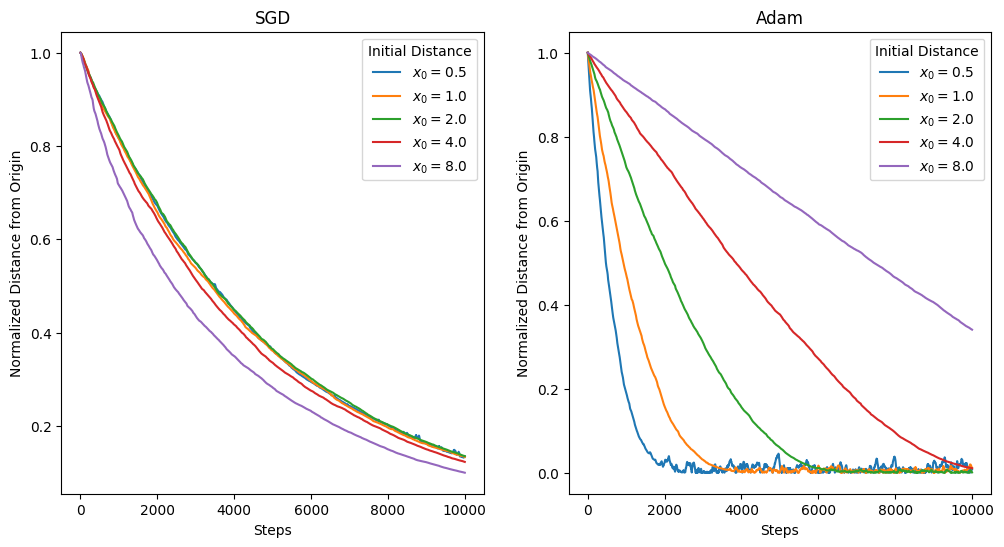

In [ ]:
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows))

# Hyperparameters
theta = np.deg2rad(0)
x0s, y0 = [0.5, 1.0, 2.0, 4.0, 8.0], 0.0
lr, mom, steps = 1e-3, 0.9, 10000
sigma = 1e-1

for i, x0 in enumerate(x0s):

    # SGD trajectory
    x = torch.tensor(x0, requires_grad=True)
    y = torch.tensor(y0, requires_grad=True)
    opt = optim.SGD((x,y), lr=lr, momentum=mom)
    SGD_trajectory = train_flat(x, y, sigma, theta, steps, opt)

    # Adam trajectory
    x = torch.tensor(x0, requires_grad=True)
    y = torch.tensor(y0, requires_grad=True)
    opt = optim.Adam((x,y), lr=lr, betas=(mom, 0.999))
    Adam_trajectory = train_flat(x, y, sigma, theta, steps, opt)

    # Plot SGD distance from origin
    axes[0].plot(np.sqrt(SGD_trajectory[:,0]**2 + SGD_trajectory[:,1]**2) / x0, label='$x_0 = ${}'.format(x0))
    axes[0].set_ylabel('Normalized Distance from Origin')
    axes[0].set_xlabel('Steps')
    axes[0].set_title("SGD")
    axes[0].legend(title="Initial Distance")

    # Plot Adam distance from origin
    axes[1].plot(np.sqrt(Adam_trajectory[:,0]**2 + Adam_trajectory[:,1]**2) / x0, label='$x_0 = ${}'.format(x0))
    axes[1].set_ylabel('Normalized Distance from Origin')
    axes[1].set_xlabel('Steps')
    axes[1].set_title("Adam")
    axes[1].legend(title="Initial Distance")

plt.show()

### Movement along the manifold determined by orientation
In this experiment we track the distance from the origin for SGD and Adam for a fixed initial distance on the manifold, but under a rotated loss landscape.  Here we rotate the function by varrying counter clock-wise rotations such that $f(x,y)$ is
$$f(x,y) = h(x \cos(\theta) - y \sin(\theta)) (x\sin(\theta) + y \cos(\theta))^2$$
and then rotate the initialization by $-\theta$ such that we mantain an initialization on the minima manifold. As you can see below, while the dynamics of SGD are invariant to the rotations ($\mathrm{Tr}(H)$ is invairant to rotations), the dynamics of Adam change signifigantly.  The less cooridnate-alligned the manifold, the slower the dynamics.  As discussed in Ma et al. 2022, when $\theta = 0$, the implicit bias for Adam is approximately $\mathrm{Tr}(\sqrt{H})$, while when $\theta = \pi / 4$, the implicit bias is approxitely $\mathrm{Tr}(\log(H))$. Thus, even though the distance is fixed from the origin in all experiments, the implicit bias driving the manifold dynamics changes based on the global orientation of the manifold.

100%|██████████| 10000/10000 [00:06<00:00, 1487.46it/s]


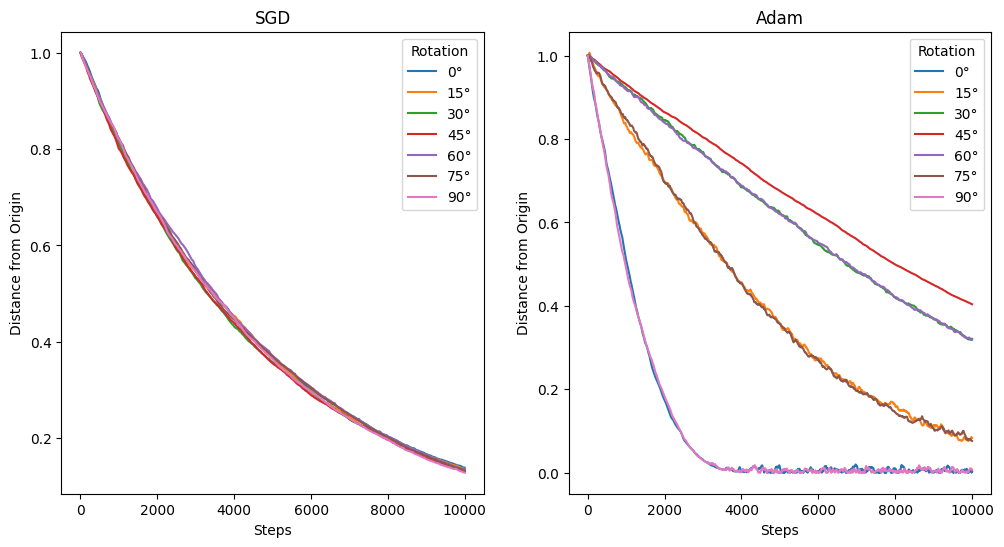

In [ ]:
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows))

# Hyperparameters
degrees = [0, 15, 30, 45, 60, 75, 90]
x0, y0 = 1, 0.0
lr, mom, steps = 1e-3, 0.9, 10000
sigma = 1e-1

for i, degree in enumerate(degrees):

    # Rotate Initialization (clockwise to make sure init. is on manifold)
    theta = np.deg2rad(degree)
    Rx0, Ry0 = np_rotate(x0, y0, -theta)

    # SGD trajectory
    x = torch.tensor(Rx0, requires_grad=True)
    y = torch.tensor(Ry0, requires_grad=True)
    opt = optim.SGD((x,y), lr=lr, momentum=mom)
    SGD_trajectory = train_flat(x, y, sigma, theta, steps, opt)

    # Adam trajectory
    x = torch.tensor(Rx0, requires_grad=True)
    y = torch.tensor(Ry0, requires_grad=True)
    opt = optim.Adam((x,y), lr=lr, betas=(mom, 0.999))
    Adam_trajectory = train_flat(x, y, sigma, theta, steps, opt)

    # Plot SGD distance from origin
    axes[0].plot(np.sqrt(SGD_trajectory[:,0]**2 + SGD_trajectory[:,1]**2), label="{}°".format(degree))
    axes[0].set_ylabel('Distance from Origin')
    axes[0].set_xlabel('Steps')
    axes[0].set_title("SGD")
    axes[0].legend(title="Rotation")

    # Plot Adam distance from origin
    axes[1].plot(np.sqrt(Adam_trajectory[:,0]**2 + Adam_trajectory[:,1]**2), label="{}°".format(degree))
    axes[1].set_ylabel('Distance from Origin')
    axes[1].set_xlabel('Steps')
    axes[1].set_title("Adam")
    axes[1].legend(title="Rotation")

plt.show()

## 2. Sombrero Potential



Here we consider a potential with rotational invariance,
$$f(x,y) = (x^2 + y^2 - 1)^2.$$
The global minima of this function lie is the circle with radius $1$, forming a curved manifold. Crucially, the $\mathrm{Tr}(H)$ is constant along the minima manifold, while neither $\mathrm{Tr}(\sqrt{H})$ or $\mathrm{Tr}(\log(H))$ are. Thus, we should expect that the dynamics of SGD do not explore the minima manifold, while Adam does. Interestingly, as we will see, Adam is actually attracted towards sparse solutions!


![landscape](https://drive.google.com/uc?export=view&id=18zyadBZ-GZtku29e7s4WtEZJqZeuC782)

In [ ]:
# Train loop for a given optimizer

def train_sombrero(x, y, sigma, theta, steps, opt):
    point = [x.detach().numpy().copy(), y.detach().numpy().copy()]
    trajectory = [point]
    for i in tqdm(range(steps)):
        opt.zero_grad()

        Rx, Ry = torch_rotate(x, y, torch.tensor(theta))
        z = sigma * torch.tensor(np.random.randn(1))
        fxy = (Rx**2 + Ry**2 - 1 + z)**2

        fxy.backward()

        opt.step()

        point = [x.detach().numpy().copy(), y.detach().numpy().copy()]
        trajectory.append(point)

    return np.array(trajectory)

### Movement along the manifold determined by initialization/orientation
In this experiment we will track the movement on the minima manifold by an angle.  Because the landscape is rotationally invariant, varrying the initialization is equivelent to varrying the orirentation. Thus, we will track the angle on the manifold for SGD and Adam for varrying initial angles. As you will see, SGD does not move, as would be expected as it preserves the rotational symmetry.  However, Adam breaks the rotational symmetry resulting in dynamics that are slowly attracted towards sparse solution. However, the dynamics near the sparse solutions are unstable because of vanishing gradients.  As a result Adam gets stuck in a limit cycle around these sparse solutions.

100%|██████████| 10000/10000 [00:07<00:00, 1412.63it/s]


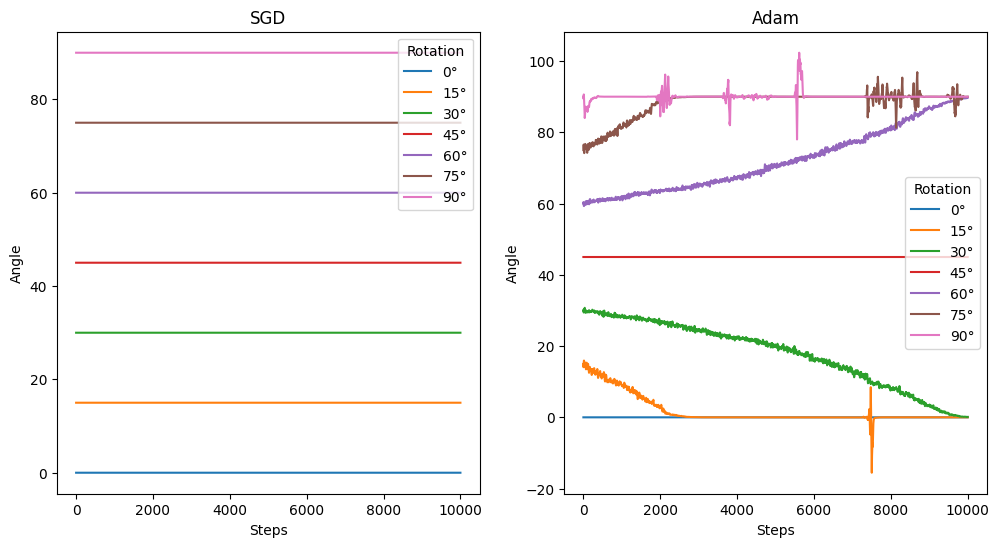

In [ ]:
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows))

# Hyperparameters
# (the learning rate has increased by an order or magntiude from the last experiment)
degrees = [0, 15, 30, 45, 60, 75, 90]
x0, y0 = 1.0, 0.0
lr, mom, steps = 1e-2, 0.9, 10000
sigma = 1e-1

for i, degree in enumerate(degrees):

    # Rotate Initialization (clockwise to make sure init. is on manifold)
    theta = np.deg2rad(degree)
    Rx0, Ry0 = np_rotate(x0, y0, theta)

    # SGD trajectory
    x = torch.tensor(Rx0, requires_grad=True)
    y = torch.tensor(Ry0, requires_grad=True)
    opt = optim.SGD((x,y), lr=lr, momentum=mom)
    SGD_trajectory = train_sombrero(x, y, sigma, 0, steps, opt)

    # Adam trajectory
    x = torch.tensor(Rx0, requires_grad=True)
    y = torch.tensor(Ry0, requires_grad=True)
    opt = optim.Adam((x,y), lr=lr, betas=(mom, 0.999))
    Adam_trajectory = train_sombrero(x, y, sigma, 0, steps, opt)

    # Plot SGD distance from origin
    SGD_radians = np.arctan2(SGD_trajectory[:,1], SGD_trajectory[:,0])
    axes[0].plot(np.rad2deg(SGD_radians), label="{}°".format(degree))
    axes[0].set_ylabel('Angle')
    axes[0].set_xlabel('Steps')
    axes[0].set_title("SGD")
    axes[0].legend(title="Rotation")

    # Plot Adam distance from origin
    Adam_radians = np.arctan2(Adam_trajectory[:,1], Adam_trajectory[:,0])
    axes[1].plot(np.rad2deg(Adam_radians), label="{}°".format(degree))
    axes[1].set_ylabel('Angle')
    axes[1].set_xlabel('Steps')
    axes[1].set_title("Adam")
    axes[1].legend(title="Rotation")

plt.show()

## 3. Success and Faliures of Adam

From the two settings above a very interesting picture begins to emerge around the dynamics of adaptive gradient methods along the minima manifold. We see that by adapting the learning rate based on the gradient norm, Adam is effectively regulating the gradient noise resulting in an implicit bias along the minima manifold minimizing something like $\mathrm{Tr}(\log(H))$ rather than $\mathrm{Tr}(H)$ as in SGD. This has three interesting implications:
1. **Slow and fast manifold dynamics.** Because Adam is minimizing something like $\mathrm{Tr}(\log(H))$ under gradient flow, when it is close to the minimizer the dynamics are very fast. However, when far from the minimizer, the dynamics are very slow. SGD is fundementally different. Its speed is linear in the curvature of the Hessian.
2. **Rotational symmetry breaking.** Due to the cyclic invariance of trace, loss landscapes with rotational symmetry will generate minima manifolds where $\mathrm{Tr}(H)$ is constant. Because of this, SGD is unable to explore the minima manifold. However, Adam minimizes $\mathrm{Tr}(\log(H))$, which is not invariant under rotation. Thus, Adam is able to break the symmetry and explore the minima manifold.
3. **Limit cycles around sparse solutions.** In particular, Adam is attracted towards minima where eigenvalues of the Hessian vanish. For rotational symmetry these points seem to be associated with sparsity. While Adam is attracted to these sparse solutions, it is unable to converge because of instability introduced by a vanishing gradient. This results in Adam being trapped in limit cycles around these points.  

These three behaviors of Adam around the manifold of minima are very interesting and might explain empirical treds of Adam compared to SGD.  For example, it is well known that LLM generalize much better when trained with Adam than SGD.  A distinct feature of LLM is there use of self-attention.  With the addition of $L_2$ regularization these self-attention units have a rotational symmetry between the key and query weight matrices.  SGD would be unable to break this symmetry, however, Adam would induce a slow dynamics towards sparse solutions, which along with the regularization would lead to a change in performance. In other cases, such as ConvNets, it was widely observed that Adam struggled to perform as well as SGD with momentum.  This might be due to the extremely slow manifold dynamics of Adam when far from the flattest solution. Based on these observation, I think we can catagorize these observations as success and failiures of Adam.

**Success:**
1. When close to the flattest solution, Adam demonstrates super fast convergence.
2. Adam's ability to break rotational symmetry allows it to explore rotationally equivelent solutions.
3. Adam is naturally attracted towards sparse solutions if one exists.

**Faliures:**
1. When far from the flattest solution, Adam demonsrates super slow convergence.
2. Near sparse solutions Adam is unstable leading to limit cycles due to vanishing gradients.

Can we consider modifications to Adam that can address these two faliures, while mantaining the success?